In [1]:
participant_id = "P1"

In [2]:
%load_ext autoreload
%autoreload 2
import importlib.util
from pathlib import Path
import os
import sys

src_folder_path = Path.cwd().parent  # go from src/pipelines → src
sys.path.append(str(src_folder_path))

VID_FILE_PATH = "../../data/raw/videos"
OUTPUT_CSV_FILE = "../../data/processed/interview_features.csv"
AUDIO_FILE_PATH = f"../../data/raw/audio/trimmed_{participant_id}.wav"

In [4]:
from utils.face_analyzer import FaceAnalyzer


face_analyzer = FaceAnalyzer()
frames = face_analyzer.get_video_frames_for_participant(
    participant_id, VID_FILE_PATH, num_selected_frames=5)

I0000 00:00:1745520418.009974 15509080 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1745520418.044179 15509862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745520418.059795 15509862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# Lexical Features

In [5]:
# from src.utils.LexicalAnalyser import LexicalAnalyser

# AUDIO_FILE_PATH = f"../../data/raw/audio/trimmed_{participant_id}.wav"
# lexical_analyser = LexicalAnalyser(AUDIO_FILE_PATH)
# # Extract all features
# lexical_features = lexical_analyser.extract_all_features()

# # Print the extracted features
# print(lexical_features)

# Facial Features

### Face Mesh

In [6]:
for frame in frames:
    detected_faces_landmarks = face_analyzer.process_image_results(frame.image)
    frame.facial_landmarks_obj= face_analyzer.get_largest_face_landmarks_obj(frame.image, detected_faces_landmarks)
    if frame.facial_landmarks_obj:
        frame.facial_landmarks = frame.facial_landmarks_obj.landmark

W0000 00:00:1745520419.458141 15509860 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


### Face

In [7]:

for frame in frames:
    if frame.facial_landmarks:
        frame.face = face_analyzer.get_face_coordinates(frame.facial_landmarks, frame.image)

### Smile

In [8]:
import numpy as np

SMOOTH_WINDOW = 5
happiness_buffer = []
def smooth_happiness(happiness_prob):
    if happiness_prob is None:
        return 0 # TODO: change?
    happiness_buffer.append(happiness_prob)
    if len(happiness_buffer) > SMOOTH_WINDOW:
        happiness_buffer.pop(0)
    return np.mean(happiness_buffer)


for i, frame in enumerate(frames):
    face_roi = face_analyzer.get_face_roi_image(frame.image, frame.face, expand_ratio=1.1)
    frame.smile = smooth_happiness(face_analyzer.get_smile_from_frame(face_roi))

Action: emotion: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


### Selected Facial Features

In [9]:
for frame in frames:
    frame.two_landmarks_connectors = face_analyzer.get_selected_facial_landmarks(frame.facial_landmarks)

### Head Pose

In [10]:
texts = []
for frame in frames:
    result = face_analyzer.get_face_angles(frame.image, frame.facial_landmarks)
    frame.face_angles = result

# Prosodic Extraction

In [12]:
from schemas.model_features import ProsodicFeatures
from utils.prosody_analyzer import ProsodyAnalyzer
 

prosody_analyzer = ProsodyAnalyzer(participant_id)
prosodic_features: ProsodicFeatures = prosody_analyzer.extract_all_features()
print(prosodic_features)

ProsodicFeatures(f0_mean=138.8311168142939, f0_min=75.34559605984698, f0_max=599.1469508185926, f0_range=523.8013547587456, f0_sd=67.08530112931376, intensity_mean=-17.989479064941406, intensity_min=-36.43029022216797, intensity_max=0.0, intensity_range=36.43029022216797, intensity_sd=7.597977638244629, f1_mean=626.2173706460609, f1_sd=255.618004717988, f2_mean=1801.0016796933116, f2_sd=369.19335979732216, f3_mean=2718.6018206978147, f3_sd=363.6766279398512, f2_f1_mean=3.2093469178503944, f3_f1_mean=4.813353523730503, f2_f1_sd=1.1984938994193113, f3_f1_sd=1.5116794397601092, jitter=0.02250039669976796, shimmer=0.17853661247111466, percent_unvoiced=14.22418608114985, percent_breaks=1.6075754239154016, max_pause_duration=2.429999999999999, avg_pause_duration=0.31397260273972616, duration=161.134)


# Features Storage

### Facial Features Aggregation

In [14]:
from utils.feature_storage import FeatureStorage


feature_storage = FeatureStorage(OUTPUT_CSV_FILE)
facial_features = feature_storage.aggregate_facial_features(frames)

In [15]:
# feature_storage.save_to_csv(participant_id, prosodic_features, facial_features, lexical_features)

# Display Frames

I0000 00:00:1745520460.822128 15509080 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1745520460.830881 15510564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745520460.846829 15510564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


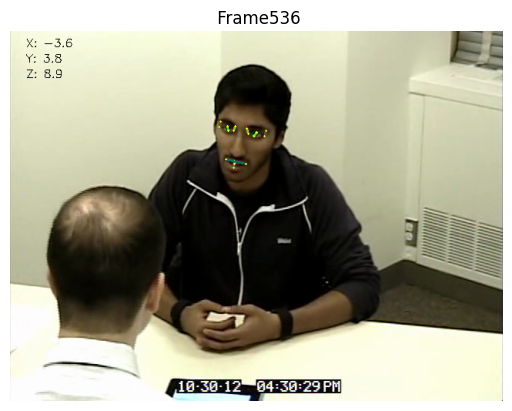

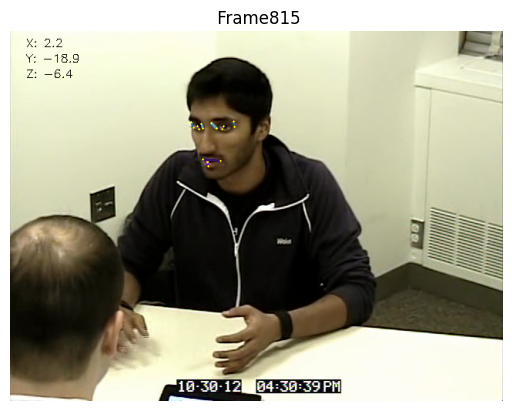

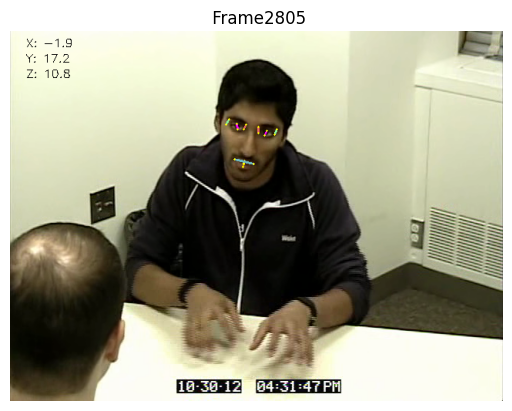

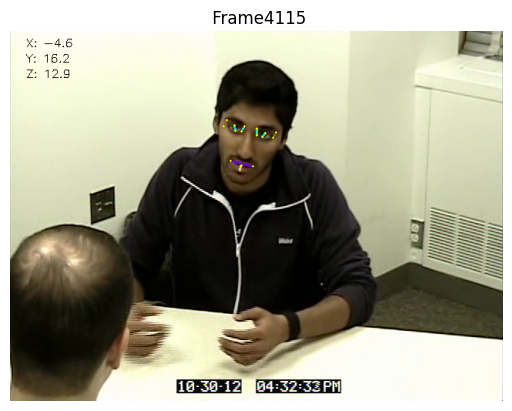

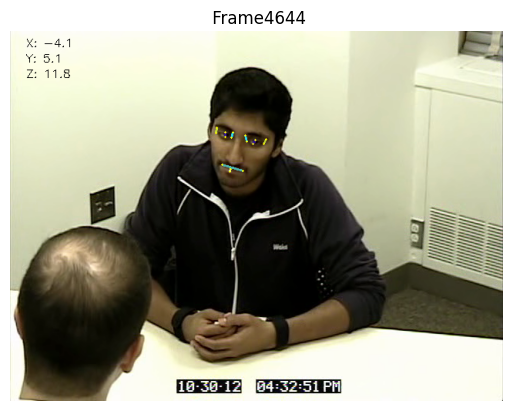

In [16]:
for frame in frames:
    frame.reset_drawable_image()
    # frame.draw_face_border()
    
    frame.draw_selected_facial_landmarks(draw_lines=True)
    
    frame.put_face_angles()
    # frame.draw_facial_landmarks()
    frame.display()